In [1]:
import argparse
import os
import sys
from os import mkdir
from apex import amp
import shutil



import torch.nn.functional as F

sys.path.append('..')
from config import cfg
from data import make_data_loader, make_data_loader_view
from engine.trainer import do_train
from modeling import build_model
from solver import make_optimizer, WarmupMultiStepLR,build_scheduler
from layers import make_loss

from utils.logger import setup_logger

from torch.utils.tensorboard import SummaryWriter
import torch
from layers.RaySamplePoint import RaySamplePoint
from engine import render
import numpy as np 
torch.cuda.set_device(2)
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
training_folder = '/data/wmy/NR/RF_training/xzq_bbox'
epoch = 12000
para_file = 'rfnr_model_%d.pth' % epoch

In [3]:
cfg.merge_from_file(os.path.join(training_folder,'configs.yml'))
cfg.MODEL.BOARDER_WEIGHT = 1e-10
cfg.freeze()

In [4]:
val_loader, dataset_val = make_data_loader_view(cfg, is_train=False)
train_loader, dataset = make_data_loader(cfg, is_train=True)

0 / 1
load 56 Ts, 56 Ks, 1 frame, 400876 vertices
dataset initialed. near: 3.008136  far: 12.583911
0 / 1
load 56 Ts, 56 Ks, 1 frame, 400876 vertices
dataset initialed. near: 3.008136  far: 12.583911
load 25684800 rays.


In [5]:
model = build_model(cfg).cuda()
model.load_state_dict(torch.load(os.path.join(training_folder,para_file),map_location='cpu'))
model.eval()
pass

In [6]:
maxs = torch.max(dataset.bbox[0], dim=0).values.cuda()+3
mins = torch.min(dataset.bbox[0], dim=0).values.cuda()-3
model.set_max_min(maxs,mins)

In [7]:
img, vs, frame_id, T, K, near_far,_ = dataset_val.NHR_dataset.__getitem__(0)
K = K.unsqueeze(0)

for batch in train_loader:
    rays, rgbs, bboxes,  near_fars, frame_ids = batch
    break

In [9]:
center = torch.mean(vs,dim=0).cpu()
up = -torch.mean(dataset_val.NHR_dataset.Ts[:,0:3,1],dim =0)
up = up / torch.norm(up)
radius = torch.norm(dataset_val.NHR_dataset.Ts[0,0:3,3] - center) * 1.3

center = center + up*radius*0.01


v = torch.tensor([0,0,-1], dtype=torch.float32)
v = v - up.dot(v)*up
v = v / torch.norm(v)

K[:,0,2] = 400
K[:,1,2] = 300

K = K.cuda()


s_pos = center - v * radius + up*radius*0.1

center = center.numpy()
up = up.numpy()
radius = radius.item()
s_pos = s_pos.numpy()

In [ ]:
import math
def rotate(angle):
    #res = np.array([ [math.cos(angle), -math.sin(angle), 0],[ math.sin(angle),math.cos(angle),0],[0,0,1] ])
    res = np.array([ [math.cos(angle), 0, math.sin(-angle)],[0,1,0],[ math.sin(-angle),0, math.cos(angle)]])
    return res

def rodrigues_rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

index = 0

dx = 1
    
if not os.path.exists(os.path.join(training_folder,'vis_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_%d'%epoch))
if not os.path.exists(os.path.join(training_folder,'vis_alpha_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_alpha_%d'%epoch))
if not os.path.exists(os.path.join(training_folder,'vis_depth_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_depth_%d'%epoch))
    
sKs = []
sTs = []
frames_id = []
    
for i in range(720):

    
    angle = 3.1415926*2*i/360.0
    #angle= 0 
    
    pos = s_pos - center
    pos = rodrigues_rotation_matrix(up,-angle).dot(pos) 
    pos = pos + center
    
    print('pos:',pos)
    
    
    lookat = center - pos
    lookat = lookat/np.linalg.norm(lookat)
    
    xaxis = np.cross(lookat, up)
    xaxis = xaxis / np.linalg.norm(xaxis)
    
    yaxis = -np.cross(xaxis,lookat)
    yaxis = yaxis/np.linalg.norm(yaxis)
    
    nR = np.array([xaxis,yaxis,lookat, pos]).T
    nR = np.concatenate([nR,np.array([[0,0,0,1]])])
    
    sTs.append(nR)
    sKs.append(K[0].cpu().numpy())
    frames_id.append(index)
    
    with torch.no_grad():
        stage2, stage1 = render(model, K[0],torch.Tensor(nR).cuda(),(600,800), bboxes = bboxes[0][0].cuda())
    


    torch.cuda.empty_cache()
    print(i,'/360')
    
    



In [10]:
import math
import time
def rotate(angle):
    #res = np.array([ [math.cos(angle), -math.sin(angle), 0],[ math.sin(angle),math.cos(angle),0],[0,0,1] ])
    res = np.array([ [math.cos(angle), 0, math.sin(-angle)],[0,1,0],[ math.sin(-angle),0, math.cos(angle)]])
    return res

def rodrigues_rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

index = 0

dx = 1
    
if not os.path.exists(os.path.join(training_folder,'vis_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_%d'%epoch))
if not os.path.exists(os.path.join(training_folder,'vis_alpha_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_alpha_%d'%epoch))
if not os.path.exists(os.path.join(training_folder,'vis_depth_%d'%epoch)):
    os.mkdir(os.path.join(training_folder,'vis_depth_%d'%epoch))
    
    
sKs = []
sTs = []
frames_id = []


latitde = 2

longitude_step = lambda x: int((1.0 - float(abs(x))/latitde)*120 + 60)



    
for j in range(0,latitde):

    print('latitde:',j)

    s_pos = (center - radius*v.numpy()  + up*radius*0.01*j)



    for i in range(longitude_step(j)):

        beg = time.time()
        angle_step = 180.0/ longitude_step(j)

        angle = 3.1415926*4*i*angle_step/360.0

        #angle= 0 

        pos = s_pos - center
        pos = rodrigues_rotation_matrix(up,-angle).dot(pos) 

        pos = pos + center

        print('pos:',pos)


        lookat = center - pos
        lookat = lookat/np.linalg.norm(lookat)

        xaxis = np.cross(lookat, up)
        xaxis = xaxis / np.linalg.norm(xaxis)

        yaxis = -np.cross(xaxis,lookat)
        yaxis = yaxis/np.linalg.norm(yaxis)

        nR = np.array([xaxis,yaxis,lookat, pos]).T
        nR = np.concatenate([nR,np.array([[0,0,0,1]])])

        sTs.append(nR)
        sKs.append(K[0].cpu().numpy())
        frames_id.append('img_%04d_%d_%d.jpg'%(index,j,i))

        with torch.no_grad():
            stage2, stage1 = render(model, K[0],torch.Tensor(nR).cuda(),(600,800),  bboxes = bboxes[0][0].cuda())  # ROI=(30,280,570,220),
            
            
        img = stage2[0].detach().cpu().numpy()
        depth = stage2[1].detach().cpu().numpy()
        alpha = stage2[2].detach().cpu().numpy()
        
        print('render time:', time.time()-beg)



        cv2.imwrite(os.path.join(training_folder,'vis_%d/img_%04d_%d_%d.jpg'%(epoch,index,j,i)),img)

        cv2.imwrite(os.path.join(training_folder,'vis_alpha_%d/img_%04d_%d_%d.jpg'%(epoch,index,j,i)  ),alpha)
        cv2.imwrite(os.path.join(training_folder,'vis_depth_%d/img_%04d_%d_%d.jpg'%(epoch,index,j,i)  ),depth)




        torch.cuda.empty_cache()
        print(i)
        break
    break



with open(os.path.join(training_folder,'Intrinsic_%d.inf'%epoch), 'w') as f:
    for i,camk in enumerate(sKs):
        f.write('%d\n'%i)
        f.write('%f %f %f\n %f %f %f\n %f %f %f\n' % tuple(camk.reshape(9).tolist()))
        f.write('\n')


with open(os.path.join(training_folder,'CamPose_%d.inf' %epoch), 'w') as f:
    for i,camT in enumerate(sTs):
        A = camT[0:3,:]
        tmp = np.concatenate( [A[0:3,2].T, A[0:3,0].T,A[0:3,1].T,A[0:3,3].T])
        f.write('%f %f %f %f %f %f %f %f %f %f %f %f\n' % tuple(tmp.tolist()))

with open(os.path.join(training_folder,'frames_%d.inf' %epoch), 'w') as f:
    for i,ids in enumerate(frames_id):
        f.write('%s\n' % ids)

latitde: 0
pos: [ 0.27990109 -4.968925   -0.99211502]
render time: 14.03273630142212
0


In [ ]:
alpha.shape

In [ ]:
img =  img.reshape(600,800, 3)

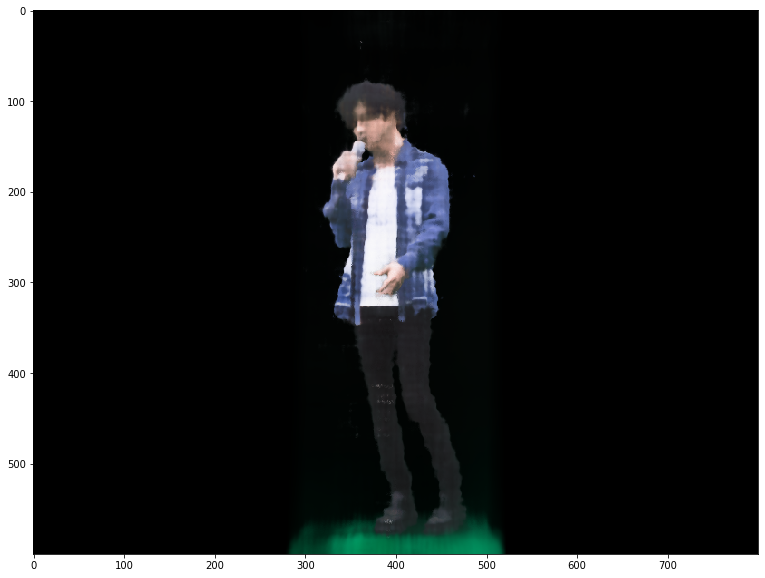

In [11]:
plt.figure(figsize=(16,10))
plt.imshow(img)

In [ ]:
bboxes[0][0]